In this notebook, we mainly utilize extreme gradient boost to improve the prediction model originially proposed in TLE 2016 November machine learning tuotrial. Extreme gradient boost can be viewed as an enhanced version of gradient boost by using a more regularized model formalization to control over-fitting, and XGB usually performs better. Applications of XGB can be found in many Kaggle competitions. Some recommended tutorrials can be found

Our work will be orginized in the follwing order:

•Background

•Exploratory Data Analysis

•Data Prepration and Model Selection

•Final Results

# Background

The dataset we will use comes from a class excercise from The University of Kansas on Neural Networks and Fuzzy Systems. This exercise is based on a consortium project to use machine learning techniques to create a reservoir model of the largest gas fields in North America, the Hugoton and Panoma Fields. For more info on the origin of the data, see Bohling and Dubois (2003) and Dubois et al. (2007).

The dataset we will use is log data from nine wells that have been labeled with a facies type based on oberservation of core. We will use this log data to train a classifier to predict facies types.

This data is from the Council Grove gas reservoir in Southwest Kansas. The Panoma Council Grove Field is predominantly a carbonate gas reservoir encompassing 2700 square miles in Southwestern Kansas. This dataset is from nine wells (with 4149 examples), consisting of a set of seven predictor variables and a rock facies (class) for each example vector and validation (test) data (830 examples from two wells) having the same seven predictor variables in the feature vector. Facies are based on examination of cores from nine wells taken vertically at half-foot intervals. Predictor variables include five from wireline log measurements and two geologic constraining variables that are derived from geologic knowledge. These are essentially continuous variables sampled at a half-foot sample rate.

The seven predictor variables are:
•Five wire line log curves include gamma ray (GR), resistivity logging (ILD_log10), photoelectric effect (PE), neutron-density porosity difference and average neutron-density porosity (DeltaPHI and PHIND). Note, some wells do not have PE.
•Two geologic constraining variables: nonmarine-marine indicator (NM_M) and relative position (RELPOS)

The nine discrete facies (classes of rocks) are:

1.Nonmarine sandstone

2.Nonmarine coarse siltstone 

3.Nonmarine fine siltstone 

4.Marine siltstone and shale 

5.Mudstone (limestone)

6.Wackestone (limestone)

7.Dolomite

8.Packstone-grainstone (limestone)

9.Phylloid-algal bafflestone (limestone)

These facies aren't discrete, and gradually blend into one another. Some have neighboring facies that are rather close. Mislabeling within these neighboring facies can be expected to occur. The following table lists the facies, their abbreviated labels and their approximate neighbors.


Facies/ Label/ Adjacent Facies

1 SS 2 

2 CSiS 1,3 

3 FSiS 2 

4 SiSh 5 

5 MS 4,6 

6 WS 5,7 

7 D 6,8 

8 PS 6,7,9 

9 BS 7,8 


# Exprolatory Data Analysis

After the background intorduction, we start to import the pandas library for some basic data analysis and manipulation. The matplotblib and seaborn are imported for data vislization. 

In [1]:
%matplotlib inline
import pandas as pd
from pandas.tools.plotting import scatter_matrix
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import matplotlib.colors as colors

import xgboost as xgb
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score
from classification_utilities import display_cm, display_adj_cm
from sklearn.model_selection import GridSearchCV


from sklearn.model_selection import validation_curve
from sklearn.datasets import load_svmlight_files
from sklearn.model_selection import StratifiedKFold, cross_val_score, LeavePGroupsOut
from sklearn.datasets import make_classification
from xgboost.sklearn import XGBClassifier
from scipy.sparse import vstack

#use a fixed seed for reproducibility
seed = 123
np.random.seed(seed)

In [2]:
filename = './facies_vectors.csv'
training_data = pd.read_csv(filename)
training_data.head(10)

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915
5,3,A1 SH,SHRIMPLIN,2795.5,73.97,0.636,14.0,13.385,3.6,1,0.894
6,3,A1 SH,SHRIMPLIN,2796.0,73.72,0.630,15.6,13.930,3.7,1,0.872
7,3,A1 SH,SHRIMPLIN,2796.5,75.65,0.625,16.5,13.920,3.5,1,0.830
8,3,A1 SH,SHRIMPLIN,2797.0,73.79,0.624,16.2,13.980,3.4,1,0.809
9,3,A1 SH,SHRIMPLIN,2797.5,76.89,0.615,16.9,14.220,3.5,1,0.787


Set columns 'Well Name' and 'Formation' to be category

In [3]:
training_data['Well Name'] = training_data['Well Name'].astype('category')
training_data['Formation'] = training_data['Formation'].astype('category')
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4149 entries, 0 to 4148
Data columns (total 11 columns):
Facies       4149 non-null int64
Formation    4149 non-null category
Well Name    4149 non-null category
Depth        4149 non-null float64
GR           4149 non-null float64
ILD_log10    4149 non-null float64
DeltaPHI     4149 non-null float64
PHIND        4149 non-null float64
PE           3232 non-null float64
NM_M         4149 non-null int64
RELPOS       4149 non-null float64
dtypes: category(2), float64(7), int64(2)
memory usage: 300.1 KB


In [4]:
training_data.describe()

/Users/littleni/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,3232.000000,4149.000000,4149.000000
mean,4.503254,2906.867438,64.933985,0.659566,4.402484,13.201066,3.725014,1.518438,0.521852
std,2.474324,133.300164,30.302530,0.252703,5.274947,7.132846,0.896152,0.499720,0.286644
min,1.000000,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000
25%,2.000000,2821.500000,44.730000,0.498000,1.600000,8.500000,NaN,1.000000,0.277000
50%,4.000000,2932.500000,64.990000,0.639000,4.300000,12.020000,NaN,2.000000,0.528000
75%,6.000000,3007.000000,79.438000,0.822000,7.500000,16.050000,NaN,2.000000,0.769000
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000


Check distribution of classes in whole dataset

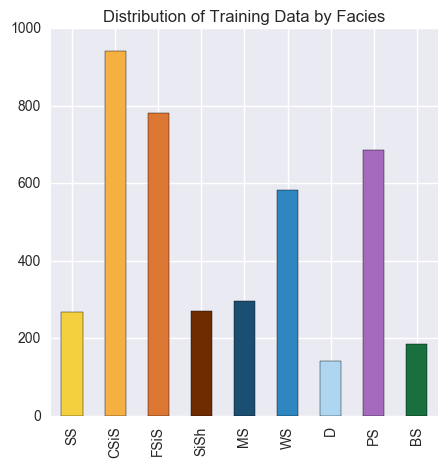

In [5]:
plt.figure(figsize=(5,5))
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00','#1B4F72',
                 '#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS','WS', 'D','PS', 'BS']

facies_counts = training_data['Facies'].value_counts().sort_index()
facies_counts.index = facies_labels
facies_counts.plot(kind='bar',color=facies_colors,title='Distribution of Training Data by Facies')

Check distribution of classes in each well

In [6]:
wells = training_data['Well Name'].unique()

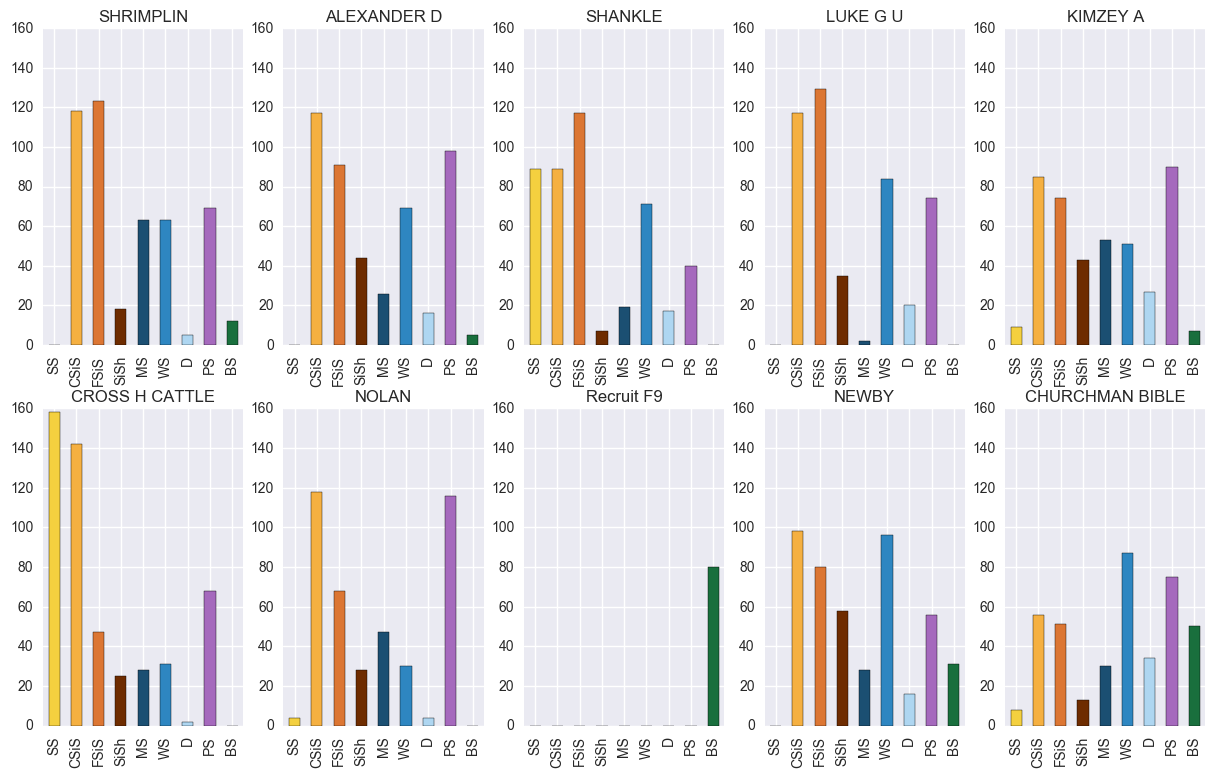

In [7]:
plt.figure(figsize=(15,9))
for index, w in enumerate(wells):
    ax = plt.subplot(2,5,index+1)

    facies_counts = pd.Series(np.zeros(9), index=range(1,10))
    facies_counts = facies_counts.add(training_data[training_data['Well Name']==w]['Facies'].value_counts().sort_index())
    #facies_counts.replace(np.nan,0)
    facies_counts.index = facies_labels
    facies_counts.plot(kind='bar',color=facies_colors,title=w)
    ax.set_ylim(0,160)

We can see that classes are very imbalanced in each well

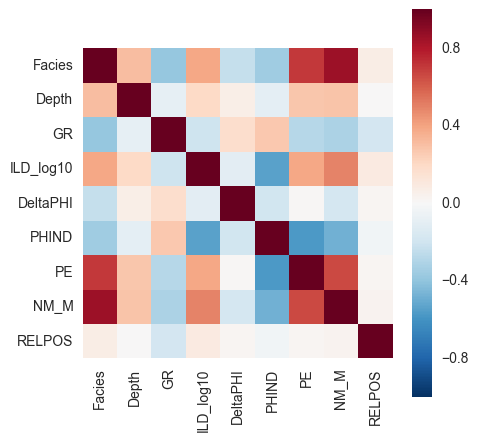

In [8]:
plt.figure(figsize=(5,5))
sns.heatmap(training_data.corr(), vmax=1.0, square=True)

# Data Preparation and Model Selection

Now we are ready to test the XGB approach, and will use confusion matrix and f1_score, which were imported, as metric for classification, as well as GridSearchCV, which is an excellent tool for parameter optimization. 

In [9]:
X_train = training_data.drop(['Facies', 'Well Name','Formation','Depth'], axis = 1 ) 
Y_train = training_data['Facies' ] - 1
dtrain = xgb.DMatrix(X_train, Y_train)

In [39]:
features = ['GR','ILD_log10','DeltaPHI','PHIND','PE','NM_M','RELPOS']

The accuracy function and accuracy_adjacent function are defined in the following to quatify the prediction correctness. 

In [10]:
def accuracy(conf):
    total_correct = 0.
    nb_classes = conf.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
    acc = total_correct/sum(sum(conf))
    return acc

adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]])

def accuracy_adjacent(conf, adjacent_facies):
    nb_classes = conf.shape[0]
    total_correct = 0.
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
        for j in adjacent_facies[i]:
            total_correct += conf[i][j]
    return total_correct / sum(sum(conf))

Before processing further, we define a functin which will help us create XGBoost models and perform cross-validation.

In [11]:
skf = StratifiedKFold(n_splits=5)

In [13]:
cv = skf.split(X_train, Y_train)

In [24]:
def modelfit(alg, Xtrain, Ytrain, useTrainCV=True, cv_fold=skf):
        
    #Fit the algorithm on the data
    alg.fit(Xtrain, Ytrain,eval_metric='merror')
        
    #Predict training set:
    dtrain_prediction = alg.predict(Xtrain)
    #dtrain_predprob = alg.predict_proba(Xtrain)[:,1]
        
    #Pring model report
    print ("\nModel Report")
    print ("Accuracy : %.4g" % accuracy_score(Ytrain,dtrain_prediction))
    print ("F1 score (Train) : %f" % f1_score(Ytrain,dtrain_prediction,average='micro'))
    #Perform cross-validation:
    if useTrainCV:
        cv_score = cross_val_score(alg, Xtrain, Ytrain, cv=cv_fold, scoring='f1_micro')
        print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % 
        (np.mean(cv_score), np.std(cv_score), np.min(cv_score), np.max(cv_score)))
    
    #Pring Feature Importance
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar',title='Feature Importances')
    plt.ylabel('Feature Importance Score')

# General Approach for Parameter Tuning

We are going to preform the steps as follows:

1.Choose a relatively high learning rate, e.g., 0.1. Usually somewhere between 0.05 and 0.3 should work for different problems. 

2.Determine the optimum number of tress for this learning rate.XGBoost has a very usefull function called as "cv" which performs cross-validation at each boosting iteration and thus returns the optimum number of tress required.

3.Tune tree-based parameters(max_depth, min_child_weight, gamma, subsample, colsample_bytree) for decided learning rate and number of trees. 

4.Tune regularization parameters(lambda, alpha) for xgboost which can help reduce model complexity and enhance performance.

5.Lower the learning rate and decide the optimal parameters.

# Step 1:Fix learning rate and number of estimators for tuning tree-based parameters

In order to decide on boosting parameters, we need to set some initial values of other parameters. Lets take the following values:

1.max_depth = 5

2.min_child_weight = 1 

3.gamma = 0 

4.subsample, colsample_bytree = 0.8 : This is a commonly used used start value. 

5.scale_pos_weight = 1

Please note that all the above are just initial estimates and will be tuned later. Lets take the default learning rate of 0.1 here and check the optimum number of trees using cv function of xgboost. The function defined above will do it for us.

In [15]:
xgb1= XGBClassifier(
    learning_rate=0.05,
    objective = 'multi:softmax',
    nthread = 4, 
    seed = seed
)

In [16]:
xgb1

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.05, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=4,
       objective='multi:softmax', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=123, silent=True, subsample=1)


Model Report
Accuracy : 0.6756
F1 score (Train) : 0.675584
CV Score : Mean - 0.5253533 | Std - 0.05590592 | Min - 0.4323671 | Max - 0.5795181


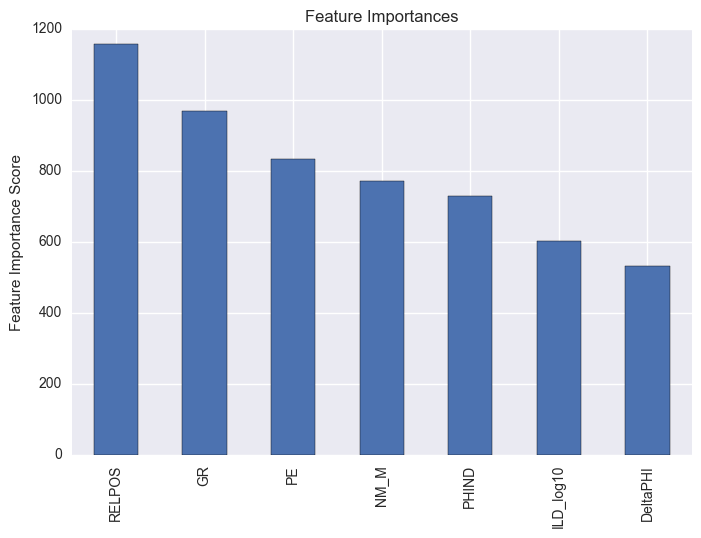

In [25]:
modelfit(xgb1, X_train, Y_train)

# Step 2: Tune max_depth and min_child_weight

In [26]:
param_test1={
    'n_estimators':range(20, 100, 10)
}

gs1 = GridSearchCV(xgb1,param_grid=param_test1, 
                   scoring='accuracy', n_jobs=4,iid=False, cv=skf)
gs1.fit(X_train, Y_train)
gs1.grid_scores_, gs1.best_params_,gs1.best_score_

/Users/littleni/anaconda/lib/python3.5/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.52342, std: 0.05811, params: {'n_estimators': 20},
  mean: 0.52221, std: 0.05941, params: {'n_estimators': 30},
  mean: 0.52509, std: 0.06253, params: {'n_estimators': 40},
  mean: 0.52583, std: 0.05667, params: {'n_estimators': 50},
  mean: 0.52703, std: 0.05816, params: {'n_estimators': 60},
  mean: 0.52511, std: 0.05431, params: {'n_estimators': 70},
  mean: 0.52558, std: 0.05486, params: {'n_estimators': 80},
  mean: 0.52535, std: 0.05566, params: {'n_estimators': 90}],
 {'n_estimators': 60},
 0.52702933462869905)

In [27]:
gs1.best_estimator_

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.05, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=60, nthread=4,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=123, silent=True, subsample=1)

In [29]:
param_test2={
    'max_depth':range(5,16,2),
    'min_child_weight':range(1,15,2)
}

gs2 = GridSearchCV(gs1.best_estimator_,param_grid=param_test2, 
                   scoring='accuracy', n_jobs=4,iid=False, cv=skf)
gs2.fit(X_train, Y_train)
gs2.grid_scores_, gs2.best_params_,gs2.best_score_

/Users/littleni/anaconda/lib/python3.5/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.52899, std: 0.06227, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.52728, std: 0.06266, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.52656, std: 0.06450, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.52873, std: 0.06452, params: {'max_depth': 5, 'min_child_weight': 7},
  mean: 0.52921, std: 0.06631, params: {'max_depth': 5, 'min_child_weight': 9},
  mean: 0.52775, std: 0.07044, params: {'max_depth': 5, 'min_child_weight': 11},
  mean: 0.52510, std: 0.06619, params: {'max_depth': 5, 'min_child_weight': 13},
  mean: 0.52174, std: 0.06052, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.52366, std: 0.05723, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.52897, std: 0.06175, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.53715, std: 0.06338, params: {'max_depth': 7, 'min_child_weight': 7},
  mean: 0.52798, std: 0.06687, params: {'max_depth': 7, 'min_child_weight': 9},
  mean: 0.52510, std: 0.06674, params:

In [30]:
gs2.best_estimator_

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.05, max_delta_step=0, max_depth=7,
       min_child_weight=7, missing=None, n_estimators=60, nthread=4,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=123, silent=True, subsample=1)


Model Report
Accuracy : 0.7932
F1 score (Train) : 0.793203
CV Score : Mean - 0.5371519 | Std - 0.06337505 | Min - 0.4227053 | Max - 0.6024096


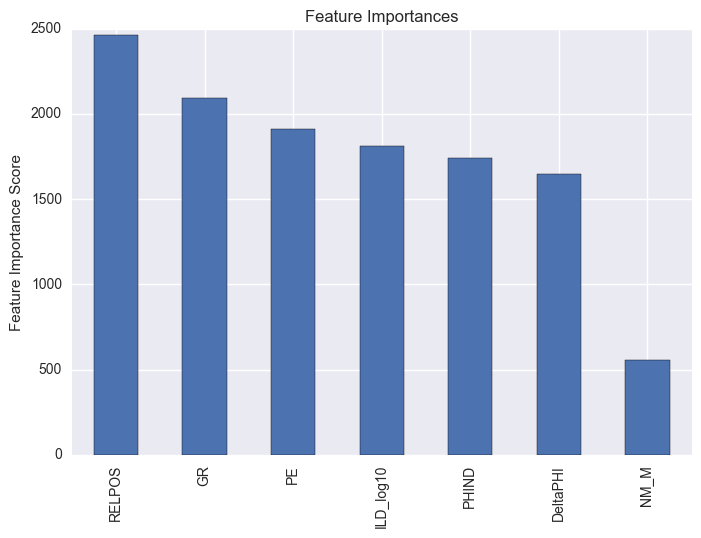

In [31]:
modelfit(gs2.best_estimator_, X_train, Y_train)

# Step 3: Tune gamma

In [32]:
param_test3={
    'gamma':[0,.05,.1,.15,.2,.3,.4],
    'subsample':[0.6,.7,.75,.8,.85,.9],
    'colsample_bytree':[i/10.0 for i in range(4,10)]
}

gs3 = GridSearchCV(gs2.best_estimator_,param_grid=param_test3, 
                   scoring='accuracy', n_jobs=4,iid=False, cv=skf)
gs3.fit(X_train, Y_train)
gs3.grid_scores_, gs3.best_params_,gs3.best_score_

/Users/littleni/anaconda/lib/python3.5/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.51742, std: 0.05528, params: {'gamma': 0, 'subsample': 0.6, 'colsample_bytree': 0.4},
  mean: 0.52104, std: 0.05652, params: {'gamma': 0, 'subsample': 0.7, 'colsample_bytree': 0.4},
  mean: 0.51863, std: 0.05843, params: {'gamma': 0, 'subsample': 0.75, 'colsample_bytree': 0.4},
  mean: 0.51982, std: 0.05658, params: {'gamma': 0, 'subsample': 0.8, 'colsample_bytree': 0.4},
  mean: 0.51911, std: 0.05845, params: {'gamma': 0, 'subsample': 0.85, 'colsample_bytree': 0.4},
  mean: 0.51719, std: 0.05397, params: {'gamma': 0, 'subsample': 0.9, 'colsample_bytree': 0.4},
  mean: 0.51838, std: 0.05525, params: {'gamma': 0.05, 'subsample': 0.6, 'colsample_bytree': 0.4},
  mean: 0.52079, std: 0.05709, params: {'gamma': 0.05, 'subsample': 0.7, 'colsample_bytree': 0.4},
  mean: 0.52007, std: 0.05982, params: {'gamma': 0.05, 'subsample': 0.75, 'colsample_bytree': 0.4},
  mean: 0.51837, std: 0.05939, params: {'gamma': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.4},
  mean: 0.52104, std: 0.0

In [33]:
gs3.best_estimator_

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0.05, learning_rate=0.05, max_delta_step=0, max_depth=7,
       min_child_weight=7, missing=None, n_estimators=60, nthread=4,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=123, silent=True, subsample=0.6)


Model Report
Accuracy : 0.7857
F1 score (Train) : 0.785732
CV Score : Mean - 0.5477532 | Std - 0.06775601 | Min - 0.4311594 | Max - 0.6228916


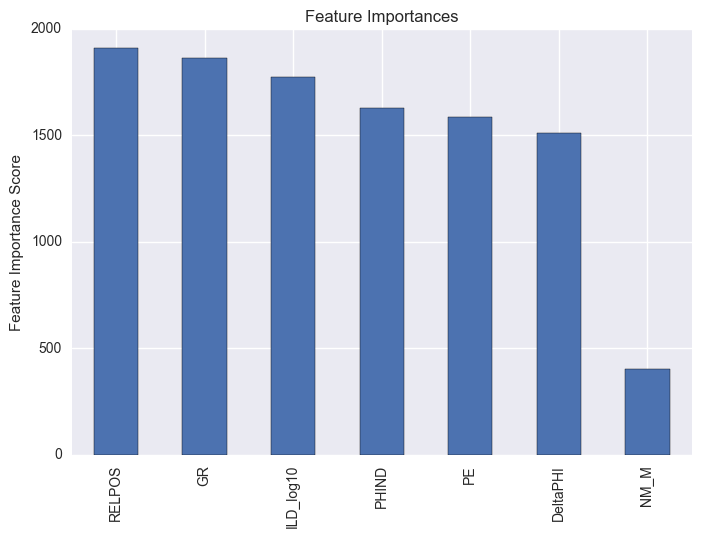

In [34]:
modelfit(gs3.best_estimator_,X_train,Y_train)

# Step 5: Tuning Regularization Parameters

In [35]:
param_test4={
    'reg_alpha':[0, 1e-5, 1e-2, 0.1, 0.2],
    'reg_lambda':[0, .25,.5,.75,.1]
}

gs4 = GridSearchCV(gs3.best_estimator_,param_grid=param_test4, 
                   scoring='accuracy', n_jobs=4,iid=False, cv=skf)
gs4.fit(X_train, Y_train)
gs4.grid_scores_, gs4.best_params_,gs4.best_score_

/Users/littleni/anaconda/lib/python3.5/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.54246, std: 0.06716, params: {'reg_lambda': 0, 'reg_alpha': 0},
  mean: 0.54318, std: 0.06594, params: {'reg_lambda': 0.25, 'reg_alpha': 0},
  mean: 0.54294, std: 0.06187, params: {'reg_lambda': 0.5, 'reg_alpha': 0},
  mean: 0.54535, std: 0.06315, params: {'reg_lambda': 0.75, 'reg_alpha': 0},
  mean: 0.54367, std: 0.06458, params: {'reg_lambda': 0.1, 'reg_alpha': 0},
  mean: 0.54174, std: 0.06755, params: {'reg_lambda': 0, 'reg_alpha': 1e-05},
  mean: 0.54342, std: 0.06608, params: {'reg_lambda': 0.25, 'reg_alpha': 1e-05},
  mean: 0.54294, std: 0.06187, params: {'reg_lambda': 0.5, 'reg_alpha': 1e-05},
  mean: 0.54535, std: 0.06315, params: {'reg_lambda': 0.75, 'reg_alpha': 1e-05},
  mean: 0.54391, std: 0.06471, params: {'reg_lambda': 0.1, 'reg_alpha': 1e-05},
  mean: 0.54246, std: 0.06682, params: {'reg_lambda': 0, 'reg_alpha': 0.01},
  mean: 0.54222, std: 0.06460, params: {'reg_lambda': 0.25, 'reg_alpha': 0.01},
  mean: 0.54366, std: 0.06576, params: {'reg_lambda': 0.5, 'reg


Model Report
Accuracy : 0.7831
F1 score (Train) : 0.783080
CV Score : Mean - 0.5480038 | Std - 0.06598781 | Min - 0.4371981 | Max - 0.6240964


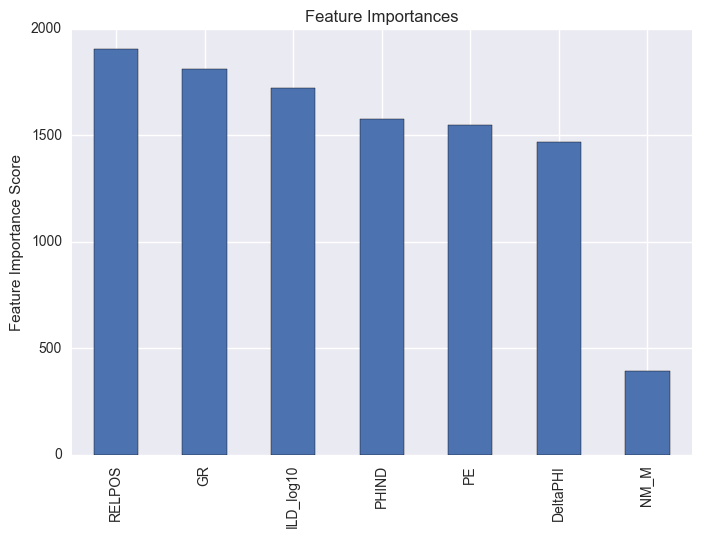

In [36]:
modelfit(gs4.best_estimator_,X_train, Y_train)

In [37]:
gs4.best_estimator_

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0.05, learning_rate=0.05, max_delta_step=0, max_depth=7,
       min_child_weight=7, missing=None, n_estimators=60, nthread=4,
       objective='multi:softprob', reg_alpha=0.2, reg_lambda=0.75,
       scale_pos_weight=1, seed=123, silent=True, subsample=0.6)

In [39]:
param_test5={
    'reg_alpha':[.15,0.2,.25,.3,.4],
}

gs5 = GridSearchCV(gs4.best_estimator_,param_grid=param_test5, 
                   scoring='accuracy', n_jobs=4,iid=False, cv=skf)
gs5.fit(X_train, Y_train)
gs5.grid_scores_, gs5.best_params_,gs5.best_score_

/Users/littleni/anaconda/lib/python3.5/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.54607, std: 0.06392, params: {'reg_alpha': 0.15},
  mean: 0.54800, std: 0.06599, params: {'reg_alpha': 0.2},
  mean: 0.54631, std: 0.06559, params: {'reg_alpha': 0.25},
  mean: 0.54655, std: 0.06266, params: {'reg_alpha': 0.3},
  mean: 0.54559, std: 0.06224, params: {'reg_alpha': 0.4}],
 {'reg_alpha': 0.2},
 0.54800375464834028)


Model Report
Accuracy : 0.7831
F1 score (Train) : 0.783080
CV Score : Mean - 0.5480038 | Std - 0.06598781 | Min - 0.4371981 | Max - 0.6240964


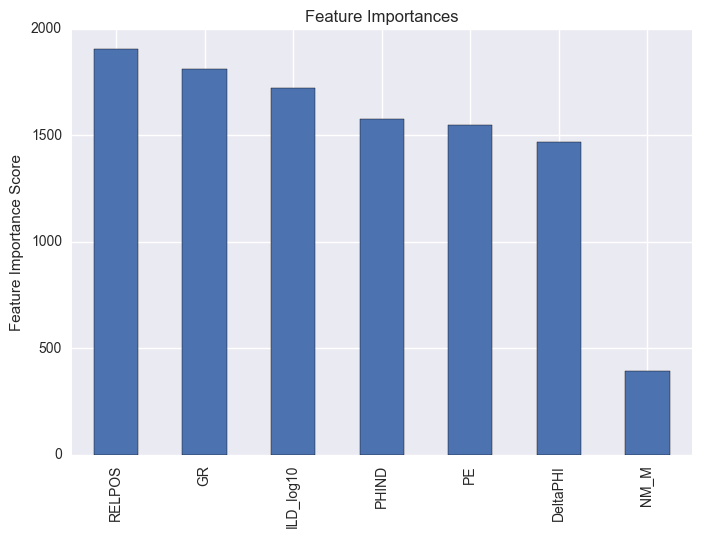

In [42]:
modelfit(gs5.best_estimator_, X_train, Y_train)

In [43]:
gs5.best_estimator_

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0.05, learning_rate=0.05, max_delta_step=0, max_depth=7,
       min_child_weight=7, missing=None, n_estimators=60, nthread=4,
       objective='multi:softprob', reg_alpha=0.2, reg_lambda=0.75,
       scale_pos_weight=1, seed=123, silent=True, subsample=0.6)

# Step 6: Reducing Learning Rate


Model Report
Accuracy : 0.784
F1 score (Train) : 0.784044
CV Score : Mean - 0.5410048 | Std - 0.06517853 | Min - 0.4311594 | Max - 0.6120482


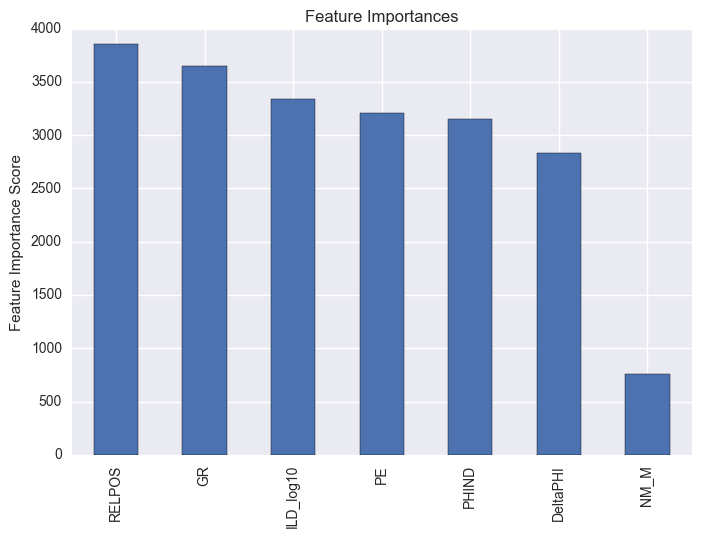

In [44]:
xgb4 = XGBClassifier(
    learning_rate = 0.025,
    n_estimators=120,
    max_depth=7,
    min_child_weight=7,
    gamma = 0.05,
    subsample=0.6,
    colsample_bytree=0.8,
    reg_alpha=0.2,
    reg_lambda =0.75,
    objective='multi:softmax',
    nthread =4,
    seed = seed,
)
modelfit(xgb4,X_train, Y_train)


Model Report
Accuracy : 0.7862
F1 score (Train) : 0.786214
CV Score : Mean - 0.5431752 | Std - 0.06553735 | Min - 0.4323671 | Max - 0.6144578


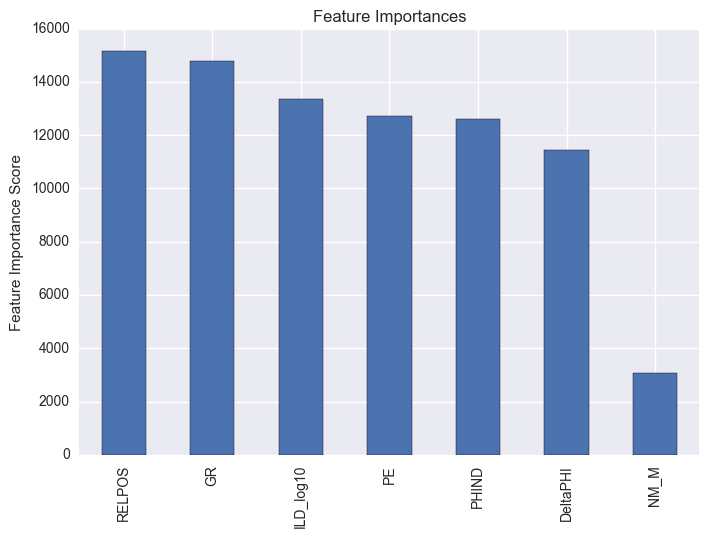

In [47]:
xgb5 = XGBClassifier(
    learning_rate = 0.00625,
    n_estimators=480,
    max_depth=7,
    min_child_weight=7,
    gamma = 0.05,
    subsample=0.6,
    colsample_bytree=0.8,
    reg_alpha=0.2,
    reg_lambda =0.75,
    objective='multi:softmax',
    nthread =4,
    seed = seed,
)
modelfit(xgb5,X_train, Y_train)

Next we use our tuned final model to do cross validation on the training data set. One of the wells will be used as test data and the rest will be the training data. Each iteration, a different well is chosen.

In [48]:
# Load data 
filename = './facies_vectors.csv'
data = pd.read_csv(filename)

# Change to category data type
data['Well Name'] = data['Well Name'].astype('category')
data['Formation'] = data['Formation'].astype('category')

X_train = data.drop(['Facies', 'Formation','Depth'], axis = 1 ) 
X_train_nowell = X_train.drop(['Well Name'], axis=1)
Y_train = data['Facies' ] - 1

# Final recommended model based on the extensive parameters search
model_final = gs5.best_estimator_
model_final.fit( X_train_nowell , Y_train , eval_metric = 'merror' )

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0.05, learning_rate=0.05, max_delta_step=0, max_depth=7,
       min_child_weight=7, missing=None, n_estimators=60, nthread=4,
       objective='multi:softprob', reg_alpha=0.2, reg_lambda=0.75,
       scale_pos_weight=1, seed=123, silent=True, subsample=0.6)

In [49]:

# Leave one well out for cross validation 
well_names = data['Well Name'].unique()
f1=[]
for i in range(len(well_names)):
    
    # Split data for training and testing

    
    train_X = X_train[X_train['Well Name'] != well_names[i] ]
    train_Y = Y_train[X_train['Well Name'] != well_names[i] ]
    test_X  = X_train[X_train['Well Name'] == well_names[i] ]
    test_Y  = Y_train[X_train['Well Name'] == well_names[i] ]

    train_X = train_X.drop(['Well Name'], axis = 1 ) 
    test_X = test_X.drop(['Well Name'], axis = 1 )

    
    # Train the model based on training data
    


    # Predict on the test set
    predictions = model_final.predict(test_X)

    # Print report
    print ("\n------------------------------------------------------")
    print ("Validation on the leaving out well " + well_names[i])
    conf = confusion_matrix( test_Y, predictions, labels = np.arange(9) )
    print ("\nModel Report")
    print ("-Accuracy: %.6f" % ( accuracy(conf) ))
    print ("-Adjacent Accuracy: %.6f" % ( accuracy_adjacent(conf, adjacent_facies) ))
    print ("-F1 Score: %.6f" % ( f1_score ( test_Y , predictions , labels = np.arange(9), average = 'weighted' ) ))
    f1.append(f1_score ( test_Y , predictions , labels = np.arange(9), average = 'weighted' ))
    facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                     'WS', 'D','PS', 'BS']
    print ("\nConfusion Matrix Results")
    from classification_utilities import display_cm, display_adj_cm
    display_cm(conf, facies_labels,display_metrics=True, hide_zeros=True)
    
print ("\n------------------------------------------------------")
print ("Final Results")
print ("-Average F1 Score: %6f" % (sum(f1)/(1.0*len(f1))))


------------------------------------------------------
Validation on the leaving out well SHRIMPLIN

Model Report
-Accuracy: 0.861996
-Adjacent Accuracy: 0.978769
-F1 Score: 0.861164

Confusion Matrix Results
     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS                                                           0
     CSiS         107    11                                       118
     FSiS          13   110                                       123
     SiSh                      15           1           2          18
       MS                       3    44    10           6          63
       WS                             2    54     1     6          63
        D                                         2     3           5
       PS                             1     4     1    63          69
       BS                                               1    11    12

Precision  0.00  0.89  0.91  0.83  0.94  0.78  0.50  0.78  1.00  0.87
   Recall

/Users/littleni/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/littleni/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



------------------------------------------------------
Validation on the leaving out well Recruit F9

Model Report
-Accuracy: 0.712500
-Adjacent Accuracy: 0.950000
-F1 Score: 0.832117

Confusion Matrix Results
     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS                                                           0
     CSiS                                                           0
     FSiS                                                           0
     SiSh                                                           0
       MS                                                           0
       WS                                                           0
        D                                                           0
       PS                                                           0
       BS                                   4     4    15    57    80

Precision  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  1.00  1.00
   Recal

Use final model to predict the given test data set

In [50]:
# Load test data
test_data = pd.read_csv('validation_data_nofacies.csv')
test_data['Well Name'] = test_data['Well Name'].astype('category')
X_test = test_data.drop(['Formation', 'Well Name', 'Depth'], axis=1)
# Predict facies of unclassified data
Y_predicted = model_final.predict(X_test)
test_data['Facies'] = Y_predicted + 1
# Store the prediction
test_data.to_csv('Prediction4.csv')

In [51]:
test_data[test_data['Well Name']=='STUART'].head()

,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,Facies
0,A1 SH,STUART,2808.0,66.276,0.630,3.3,10.65,3.591,1,1.000,2
1,A1 SH,STUART,2808.5,77.252,0.585,6.5,11.95,3.341,1,0.978,3
2,A1 SH,STUART,2809.0,82.899,0.566,9.4,13.60,3.064,1,0.956,2
3,A1 SH,STUART,2809.5,80.671,0.593,9.5,13.25,2.977,1,0.933,2
4,A1 SH,STUART,2810.0,75.971,0.638,8.7,12.35,3.020,1,0.911,2


In [52]:
test_data[test_data['Well Name']=='CRAWFORD'].head()

,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,Facies
474,A1 LM,CRAWFORD,2972.5,49.675,0.845,3.905,11.175,3.265,2,1.000,8
475,A1 LM,CRAWFORD,2973.0,34.435,0.879,3.085,8.175,3.831,2,0.991,8
476,A1 LM,CRAWFORD,2973.5,26.178,0.920,2.615,4.945,4.306,2,0.981,8
477,A1 LM,CRAWFORD,2974.0,19.463,0.967,0.820,3.820,4.578,2,0.972,8
478,A1 LM,CRAWFORD,2974.5,19.260,0.995,0.320,3.630,4.643,2,0.962,8


In [57]:
def make_facies_log_plot(logs, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

In [56]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

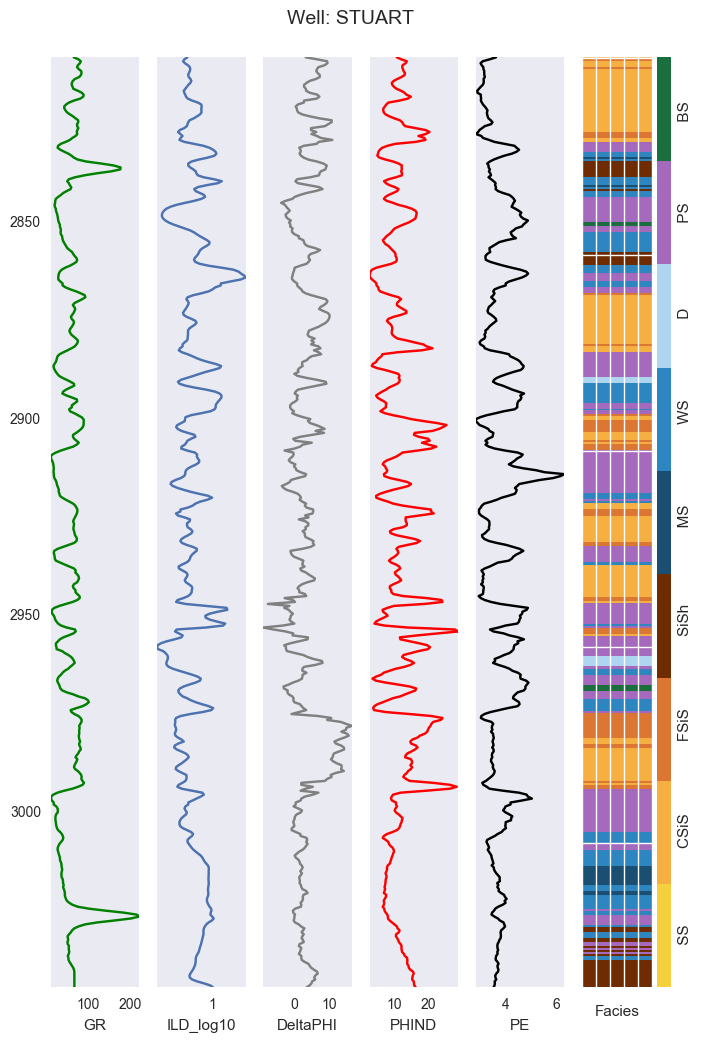

In [58]:
make_facies_log_plot(
    test_data[test_data['Well Name'] == 'STUART'],
    facies_colors)